<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/code/D2l_8_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import time

데이터셋 준비
* 이미지는 STL10 사용
* 이미지 256x256으로 resize
* crop 224x224
* horizontal flip

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.STL10(root='./data',
                                       split='train',
                                       download=True,
                                       transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=32,
                                           shuffle=True)
test_set = torchvision.datasets.STL10(root='./data',
                                      split='test',
                                      download=True,
                                      transform=transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=False)

100%|██████████| 2640397119/2640397119 [01:18<00:00, 33450200.42it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


VGG-A 모델링

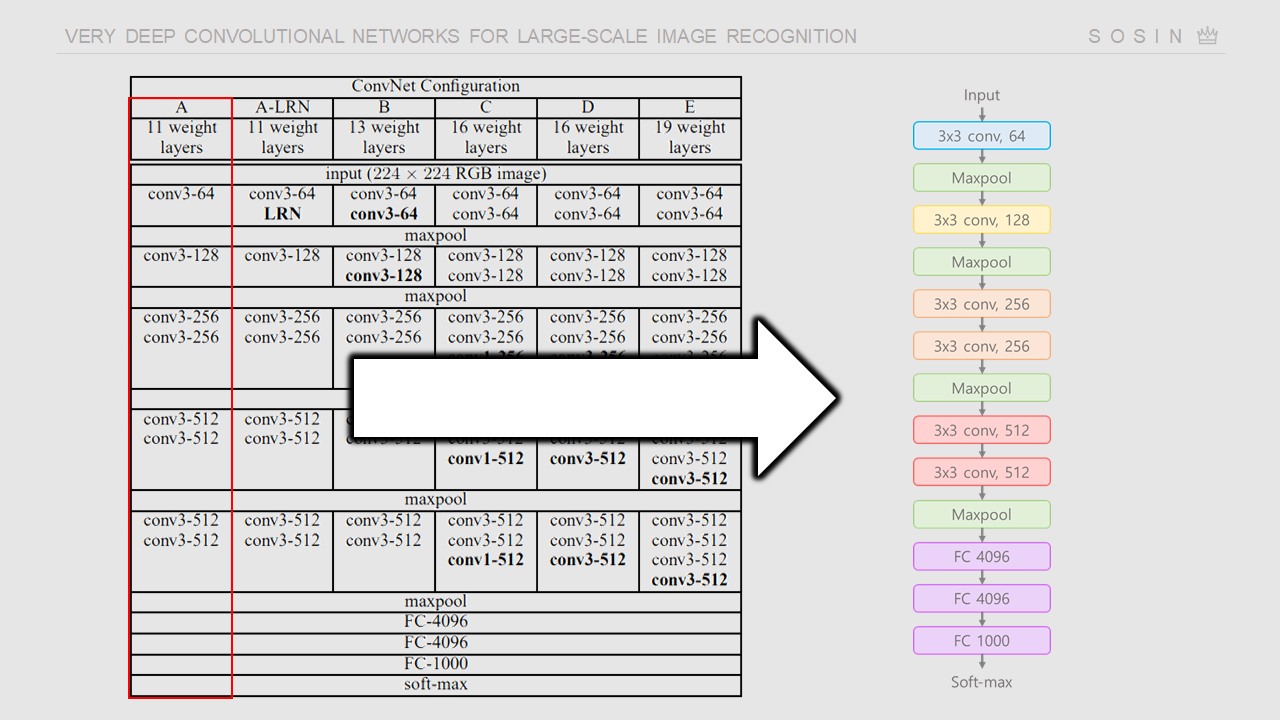


In [4]:
class VGG_A(nn.Module):
    def __init__(self, num_classes: int = 1000, init_weights: bool = True):
        super(VGG_A, self).__init__()
        self.convnet = nn.Sequential(
            # input channel (RGB : 3)
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 이미지 사이즈 224 -> 112

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 이미지 사이즈 112 -> 56

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 이미지 사이즈 56 -> 28

            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 이미지 사이즈 28 -> 14

            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 이미지 사이즈 14 -> 7
        )

        self.fclayer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x:torch.Tensor):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

Train

In [5]:
use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda:  True


In [7]:
vgg11 = VGG_A(num_classes = 10)
vgg11 = vgg11.to(device)

classes = ('airplance', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(vgg11.parameters(), lr=0.00001)

start_time = time.time()
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg11(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print(time.time() - start_time)
print('Finished Training')

[1,    50] loss: 2.303
[1,   100] loss: 2.303
[1,   150] loss: 2.302
[2,    50] loss: 2.266
[2,   100] loss: 2.225
[2,   150] loss: 2.207
[3,    50] loss: 2.200
[3,   100] loss: 2.193
[3,   150] loss: 2.179
158.27520489692688
Finished Training


Validation

In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = vgg11(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]
    ))

Accuracy of airplance : 38 %
Accuracy of  bird :  1 %
Accuracy of   car : 17 %
Accuracy of   cat : 20 %
Accuracy of  deer :  0 %
Accuracy of   dog :  6 %
Accuracy of horse : 58 %
Accuracy of monkey :  2 %
Accuracy of  ship : 10 %
Accuracy of truck : 67 %
